In [14]:
import nibabel as nib
from matplotlib import pyplot as plt
import os
import pickle
import numpy as np
import copy

#NN
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

# GPU
from tensorflow.python.client import device_lib

In [15]:
# Check GPU Detected
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7377042008126547429
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7129487770
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8185606986772269831
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Functions

In [16]:
def showImage(img, title):
    plt.imshow(img, cmap = "gray", origin = 'upper')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

In [17]:
def saveModel(directory_name, model, history):
    

    model.save(directory_name + "_Model.h5")

In [18]:
#https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default,%20f1%20score%20is%20not%20part%20of,each%20epoch,%20need%20to%20make%20some%20more%20efforts.
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [19]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [20]:
#https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py
gamma = 2
alpha = .25
def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

## Grouping Files into Datasets

In [21]:
#base_path="C:/Users/drago/Documents/gitrepos/individual-project-alzhiemers_detection/MRI Data/WM parc data - cropped images/Blur_Contour_Crop/"
base_path="C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/MRI Data/WM parc data - cropped images/Blur_Contour_Crop/"

In [22]:
# Break:
# 196 : 97 : 97
# 359 : 178 : 178

In [23]:
# File setup check
print("Total training AD: ", len(os.listdir(base_path+"1-Train/AD")))
print("Total validation AD: ", len(os.listdir(base_path+"2-Validation/AD")))
print("Total testing AD: ", len(os.listdir(base_path+"3-Test/AD")))

print("\nTotal training CN: ", len(os.listdir(base_path+"1-Train/CN")))
print("Total validation CN: ", len(os.listdir(base_path+"2-Validation/CN")))
print("Total testing CN: ", len(os.listdir(base_path+"3-Test/CN")))

Total training AD:  196
Total validation AD:  97
Total testing AD:  97

Total training CN:  359
Total validation CN:  178
Total testing CN:  178


In [24]:
cross_val = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/MRI Data/WM parc data - cropped images/Blur_Contour_Expand_Crop-Cats_Combined/Cross_Val/"

In [25]:
# Build from directory dataset generators
train_aug_datagen = ImageDataGenerator(
    rescale=1./256,
    rotation_range=5,
    width_shift_range=[-0.01, 0.01],
    height_shift_range=[-0.01, 0.01],
    zoom_range=[1-0.01, 1+0.01],
    fill_mode='nearest')

test_aug_datagen = ImageDataGenerator(rescale=1./256)

cross_val_aug_generator = train_aug_datagen.flow_from_directory(
    cross_val,
    target_size=(200,200),
    batch_size=32,
    class_mode="binary")
# Augmented generators for fitting and fine tuning 'best' model

"""
train_aug_generator = train_aug_datagen.flow_from_directory(
    base_path+"1-Train/",
    target_size=(200,200),
    batch_size=32,
    class_mode="binary")

validation_aug_generator = test_aug_datagen.flow_from_directory(
    base_path+"2-Validation/",
    target_size=(255,255),
    batch_size=32,
    class_mode="binary")
"""
"""
test_aug_generator = test_aug_datagen.flow_from_directory(
    base_path+"3-test/",
    target_size=(256,256),
    batch_size=32,
    class_mode="binary")
"""

Found 829 images belonging to 2 classes.


'\ntest_aug_generator = test_aug_datagen.flow_from_directory(\n    base_path+"3-test/",\n    target_size=(256,256),\n    batch_size=32,\n    class_mode="binary")\n'

### Data Preprosessing

In [26]:
len(cross_val_aug_generator)

52

In [27]:
# Check batches shape
count = 0
data = []
labels = []


for batch, label in cross_val_aug_generator:
    if count == 0:
        data = copy.deepcopy(batch)
        labels = copy.deepcopy(label)
    else:
        data = np.append(data, batch, axis=0)
        labels = np.append(labels, label, axis=0)
    
    count += 1
    if count >= (len(cross_val_aug_generator)/2):
        break
print(data.shape)

(416, 200, 200, 3)


In [28]:
print(data.shape)
print(labels.shape)

(416, 200, 200, 3)
(416,)


## Construct Model- 2 Dense

In [29]:
# Construct model
def construct_model(num_layers = 2, drop_layers = 0, current_optimizer = "RMSProp", current_lr = 2e-5):
    
    #param: current_metrics = "f1"
    conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(200, 200, 3))

    augmentedVGG16 = models.Sequential()
    augmentedVGG16.add(conv_base)
    augmentedVGG16.add(layers.Flatten())
    augmentedVGG16.add(layers.Dense(256, activation='relu'))
    
    if drop_layers:
        augmentedVGG16.add(layers.Dropout(.25))
    
    if num_layers == 3:
        augmentedVGG16.add(layers.Dense(256, activation='relu'))
        if drop_layers:
            augmentedVGG16.add(layers.Dropout(.25))
        
    augmentedVGG16.add(layers.Dense(1, activation='sigmoid'))

    # Freeze CNN
    conv_base.trainable=False

    # Optimiser
    if current_optimizer == "RMSProp":
        optim = optimizers.RMSprop(lr=current_lr)
    elif current_optimizer == "Adam":
        optim = optimizers.Adam(lr=current_lr)
        
    # Loss function
    #if current_loss == "focal":
    #    loss_func = focal_loss_fixed
    #else:
    #    loss_func = 'binary_crossentropy'
    
    # Metric
    #if current_metrics == "f1":
    #    metr = get_f1
    #else:
    #    metr = matthews_correlation
    #print("Metric: ", metr)
    # Model Compile
    augmentedVGG16.compile(optimizer=optim, loss=focal_loss_fixed, metrics = ['acc'])
    
    return augmentedVGG16

In [30]:
_num_layers = [2, 3]
_dropout = [0, 1]
_optimisers = ["RMSProp", "Adam"]
_learn_rate = [1e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5]
_metrics = ["f1", "mcc"]
#_losses = ["focal", "binary_crossentropy"]
parameters = dict(num_layers = _num_layers,
                  drop_layers = _dropout,
                  current_optimizer = _optimisers,
                  current_lr = _learn_rate)
                  #current_metrics = _metrics
print(parameters)

{'num_layers': [2, 3], 'drop_layers': [0, 1], 'current_optimizer': ['RMSProp', 'Adam'], 'current_lr': [1e-06, 1e-05, 2e-05, 3e-05, 4e-05, 5e-05]}


In [31]:
VGG16_model = KerasClassifier(build_fn=construct_model,epochs=30,batch_size=len(cross_val_aug_generator))

### Hypertuning Model RandomSearchCV

In [32]:
# Create checkpoint callback to store best acc to loss model
#checkpoint = ModelCheckpoint(filepath=best_model_file, save_best_only=True)

model_tuner = RandomizedSearchCV(VGG16_model, param_distributions=parameters, cv=3, n_iter=15)
tuning_results = model_tuner.fit(data, labels)

print('Best score is: {} using {}'.format(tuning_results.best_score_, tuning_results.best_params_))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
277/277 [==============================] - 5s 18ms/sample - loss: 0.1232 - acc: 0.3971
Epoch 2/30
 52/277 [====>.........................] - ETA: 0s - loss: 0.0976 - acc: 0.3846

KeyboardInterrupt: 

### Hypertuning Model GridSearchCV

In [19]:
model_tuner = GridSearchCV(VGG16_model, param_grid=parameters, cv=3, verbose=1)
tuning_results = model_tuner.fit(data, labels)

print('Best score is: {} using {}'.format(tuning_results.best_score_, tuning_results.best_params_))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
552/552 [==============================] - 6s 12ms/sample - loss: 0.0749 - acc: 0.3551
Epoch 2/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0729 - acc: 0.3841
Epoch 3/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0723 - acc: 0.4004
Epoch 4/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0717 - acc: 0.4040
Epoch 5/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0711 - acc: 0.4058
Epoch 6/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0705 - acc: 0.4076
Epoch 7/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0701 - acc: 0.4257
Epoch 8/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0695 - acc: 0.4239
Epoch 9/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0692 - acc: 0.4257
Epoch 10/30
552/552 [===========

Epoch 20/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0659 - acc: 0.4846
Epoch 21/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0657 - acc: 0.4684
Epoch 22/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0654 - acc: 0.4702
Epoch 23/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0651 - acc: 0.4882
Epoch 24/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0648 - acc: 0.4955
Epoch 25/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0646 - acc: 0.5081
Epoch 26/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0643 - acc: 0.5099
Epoch 27/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0640 - acc: 0.4937
Epoch 28/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0637 - acc: 0.4973
Epoch 29/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0635 - acc: 0.5262
Epoch 30/30
276/276 

Epoch 11/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0683 - acc: 0.3888
Epoch 12/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0681 - acc: 0.3942
Epoch 13/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0678 - acc: 0.3816
Epoch 14/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0676 - acc: 0.4033
Epoch 15/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0674 - acc: 0.3960
Epoch 16/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0672 - acc: 0.3924
Epoch 17/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0670 - acc: 0.3978
Epoch 18/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0667 - acc: 0.3978
Epoch 19/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0665 - acc: 0.3978
Epoch 20/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0663 - acc: 0.4412
Epoch 21/30
553/553 

553/553 [==============================] - 2s 4ms/sample - loss: 0.0795 - acc: 0.4684
Epoch 25/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0810 - acc: 0.4629
Epoch 26/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0756 - acc: 0.5063
Epoch 27/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0759 - acc: 0.5063
Epoch 28/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0803 - acc: 0.4846
Epoch 29/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0744 - acc: 0.5081
Epoch 30/30
276/276 [==============================] - 1s 5ms/sample - loss: 0.0677 - acc: 0.3732
Epoch 1/30
553/553 [==============================] - 3s 5ms/sample - loss: 0.1071 - acc: 0.5624
Epoch 2/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0975 - acc: 0.5588
Epoch 3/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0894 - acc: 0.5461
Epoch 4/30
553/553 [===============

553/553 [==============================] - 2s 4ms/sample - loss: 0.0699 - acc: 0.4159
Epoch 16/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0696 - acc: 0.4268
Epoch 17/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0693 - acc: 0.4286
Epoch 18/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0690 - acc: 0.4195
Epoch 19/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0687 - acc: 0.4177
Epoch 20/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0684 - acc: 0.4376
Epoch 21/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0681 - acc: 0.4394
Epoch 22/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0678 - acc: 0.4485
Epoch 23/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0676 - acc: 0.4611
Epoch 24/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0672 - acc: 0.4593
Epoch 25/30
553/553 [===========

553/553 [==============================] - 2s 4ms/sample - loss: 0.0695 - acc: 0.3906
Epoch 7/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0691 - acc: 0.3978
Epoch 8/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0688 - acc: 0.4033
Epoch 9/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0684 - acc: 0.4087
Epoch 10/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0681 - acc: 0.4087
Epoch 11/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0678 - acc: 0.4014
Epoch 12/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0674 - acc: 0.4051
Epoch 13/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0671 - acc: 0.4195
Epoch 14/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0668 - acc: 0.4304
Epoch 15/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0665 - acc: 0.4322
Epoch 16/30
553/553 [==============

552/552 [==============================] - 2s 4ms/sample - loss: 0.0780 - acc: 0.4511
Epoch 18/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0783 - acc: 0.4583
Epoch 19/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0803 - acc: 0.4457
Epoch 20/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0776 - acc: 0.4638
Epoch 21/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0756 - acc: 0.4674
Epoch 22/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0763 - acc: 0.4674
Epoch 23/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0796 - acc: 0.4547
Epoch 24/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0734 - acc: 0.5036
Epoch 25/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0744 - acc: 0.4783
Epoch 26/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0730 - acc: 0.5326
Epoch 27/30
552/552 [===========

553/553 [==============================] - 2s 4ms/sample - loss: 0.0385 - acc: 0.8300
Epoch 30/30
276/276 [==============================] - 1s 5ms/sample - loss: 0.0531 - acc: 0.6667
Epoch 1/30
552/552 [==============================] - 3s 5ms/sample - loss: 0.0733 - acc: 0.3967
Epoch 2/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0673 - acc: 0.4493
Epoch 3/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0643 - acc: 0.4964
Epoch 4/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0627 - acc: 0.5236
Epoch 5/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0601 - acc: 0.5761
Epoch 6/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0591 - acc: 0.6105
Epoch 7/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0565 - acc: 0.6522
Epoch 8/30
552/552 [==============================] - 2s 4ms/sample - loss: 0.0554 - acc: 0.6612
Epoch 9/30
552/552 [====================

553/553 [==============================] - 2s 4ms/sample - loss: 0.0586 - acc: 0.6546
Epoch 12/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0545 - acc: 0.6691
Epoch 13/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0577 - acc: 0.6655
Epoch 14/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0572 - acc: 0.6420
Epoch 15/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0547 - acc: 0.6854
Epoch 16/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0552 - acc: 0.6673
Epoch 17/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0548 - acc: 0.6618
Epoch 18/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0530 - acc: 0.6872
Epoch 19/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0507 - acc: 0.7306
Epoch 20/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0491 - acc: 0.7414
Epoch 21/30
553/553 [===========

Epoch 24/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0384 - acc: 0.8101
Epoch 25/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0375 - acc: 0.8427
Epoch 26/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0365 - acc: 0.8933
Epoch 27/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0366 - acc: 0.8119
Epoch 28/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0361 - acc: 0.8662
Epoch 29/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0349 - acc: 0.8969
Epoch 30/30
276/276 [==============================] - 1s 5ms/sample - loss: 0.0585 - acc: 0.6848
Epoch 1/30
553/553 [==============================] - 3s 5ms/sample - loss: 0.0902 - acc: 0.4575
Epoch 2/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0767 - acc: 0.4231
Epoch 3/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0733 - acc: 0.4322
Epoch 4/30
553/553 [===

Epoch 15/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0473 - acc: 0.7740
Epoch 16/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0462 - acc: 0.8300
Epoch 17/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0450 - acc: 0.7649
Epoch 18/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0439 - acc: 0.8029
Epoch 19/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0429 - acc: 0.8264
Epoch 20/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0419 - acc: 0.8192
Epoch 21/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0412 - acc: 0.8354
Epoch 22/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0403 - acc: 0.8409
Epoch 23/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0392 - acc: 0.8354
Epoch 24/30
553/553 [==============================] - 2s 4ms/sample - loss: 0.0382 - acc: 0.8354
Epoch 25/30
553/553 

552/552 [==============================] - 3s 6ms/sample - loss: 0.0506 - acc: 0.7120
Epoch 27/30
552/552 [==============================] - 3s 6ms/sample - loss: 0.0502 - acc: 0.7228
Epoch 28/30
552/552 [==============================] - 3s 6ms/sample - loss: 0.0483 - acc: 0.7446
Epoch 29/30
552/552 [==============================] - 3s 5ms/sample - loss: 0.0462 - acc: 0.7736
Epoch 30/30
277/277 [==============================] - 2s 7ms/sample - loss: 0.0655 - acc: 0.6245
Epoch 1/30


C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\matth\anaconda3\envs\gw\lib\s

Epoch 1/30


C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\matth\anaconda3\envs\gw\lib\s

Epoch 1/30


C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\matth\anaconda3\envs\gw\lib\s

Epoch 1/30


C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\matth\anaconda3\envs\gw\lib\s

Epoch 1/30


C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\matth\anaconda3\envs\gw\lib\s

Epoch 1/30


C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\matth\anaconda3\envs\gw\lib\s

Epoch 1/30


C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\matth\anaconda3\envs\gw\lib\s

Epoch 1/30


C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\matth\anaconda3\envs\gw\lib\s

Epoch 1/30


C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\matth\anaconda3\envs\gw\lib\s

Epoch 1/30


C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\matth\anaconda3\envs\gw\lib\s

Epoch 1/30


C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\matth\anaconda3\envs\gw\lib\s

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[3,3,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node block1_conv2_59/kernel/Initializer/random_uniform/RandomUn

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[3,3,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node block1_conv2_60/kernel/Initializer/random_uniform/RandomUn

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block2_conv2_61/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block2_conv2_62/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block2_conv2_63/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block2_conv2_64/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block2_conv2_65/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block2_conv2_66/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block2_conv2_67/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block2_conv2_68/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block2_conv2_69/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[3,3,128,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node block3_conv1_70/kernel/Initializer/random_uniform/Random

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_71/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_72/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_73/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_74/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_75/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_76/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_77/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_78/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_79/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_80/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_81/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_82/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_83/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_84/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_85/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_86/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_87/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_88/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_89/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_90/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_91/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_92/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_93/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_94/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_95/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_96/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_97/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_98/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_99/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback (

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_100/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_101/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_102/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_103/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_104/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_105/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_106/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_107/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_108/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_109/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_110/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_111/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_112/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_113/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_114/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_115/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_116/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_117/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_118/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_119/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_120/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_121/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_122/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_123/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_124/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_125/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_126/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_127/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_128/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_129/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_130/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_131/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_132/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_133/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_134/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_135/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_136/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_137/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_138/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_139/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_140/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_141/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_142/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1356, in _do_call
    return fn(*args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1341, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\client\session.py", line 1429, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node block5_conv3_143/kernel/Initializer/random_uniform/sub}}]]

During handling of the above exception, another exception occurred:

Traceback 

ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[node block5_conv3_144/kernel/Initializer/random_uniform/sub (defined at C:\Users\matth\anaconda3\envs\gw\lib\site-packages\keras_applications\vgg16.py:172) ]]

Original stack trace for 'block5_conv3_144/kernel/Initializer/random_uniform/sub':
  File "C:\Users\matth\anaconda3\envs\gw\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\matth\anaconda3\envs\gw\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\matth\anaconda3\envs\gw\lib\asyncio\base_events.py", line 541, in run_forever
    self._run_once()
  File "C:\Users\matth\anaconda3\envs\gw\lib\asyncio\base_events.py", line 1786, in _run_once
    handle._run()
  File "C:\Users\matth\anaconda3\envs\gw\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
    ret = callback()
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tornado\gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\ipykernel\kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\IPython\core\interactiveshell.py", line 2878, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\IPython\core\interactiveshell.py", line 2923, in _run_cell
    return runner(coro)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\IPython\core\interactiveshell.py", line 3147, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-334dd7e74fe0>", line 2, in <module>
    tuning_results = model_tuner.fit(data, labels)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\sklearn\model_selection\_search.py", line 765, in fit
    self.best_estimator_.fit(X, y, **fit_params)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 157, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "<ipython-input-16-e104d88de62a>", line 7, in construct_model
    input_shape=(200, 200, 3))
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\applications\__init__.py", line 70, in wrapper
    return base_fun(*args, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\applications\vgg16.py", line 32, in VGG16
    return vgg16.VGG16(*args, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\keras_applications\vgg16.py", line 172, in VGG16
    name='block5_conv3')(x)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 591, in __call__
    self._maybe_build(inputs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1881, in _maybe_build
    self.build(input_shapes)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\layers\convolutional.py", line 165, in build
    dtype=self.dtype)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 384, in add_weight
    aggregation=aggregation)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\training\tracking\base.py", line 663, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\base_layer_utils.py", line 155, in make_variable
    shape=variable_shape if variable_shape.rank else None)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\ops\variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\ops\variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\ops\variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2495, in default_variable_creator
    shape=shape)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\ops\variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 460, in __init__
    shape=shape)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 604, in _init_from_args
    initial_value() if init_from_fn else initial_value,
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\keras\engine\base_layer_utils.py", line 135, in <lambda>
    init_val = lambda: initializer(shape, dtype=dtype)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\ops\init_ops.py", line 533, in __call__
    shape, -limit, limit, dtype, seed=self.seed)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\ops\random_ops.py", line 248, in random_uniform
    return math_ops.add(rnd * (maxval - minval), minval, name=name)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\ops\math_ops.py", line 884, in binary_op_wrapper
    return func(x, y, name=name)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 10855, in sub
    "Sub", x=x, y=y, name=name)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


### Retrieving Saved Model and History

In [28]:
# Get history
with open(history_file_name, 'rb') as file__pi:
    VGG16_history = pickle.load(file__pi)
    
# Get best model
VGG16_best = models.load_model(best_model_file, custom_objects={"focal_loss_fixed": focal_loss_fixed})
#Temp for unused metrics
#, "get_f1": get_f1, "matthews_correlation": matthews_correlation

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Plotting Results

In [30]:
accuracy = VGG16_history['acc']
validation_accuracy = VGG16_history['val_acc']

loss = VGG16_history['loss']
validation_loss = VGG16_history['val_loss']
"""
precision = VGG16_augmented_history.history['precision']
validation_precision = VGG16_augmented_history.history['val_precision']
recall = VGG16_augmented_history.history['recall']
validation_recall = VGG16_augmented_history.history['val_recall']
f1 = VGG16_augmented_history.history['get_f1']
validation_f1 = VGG16_augmented_history.history['val_get_f1']
mcc = VGG16_augmented_history.history['matthews_correlation']
validation_mcc = VGG16_augmented_history.history['val_matthews_correlation']
"""

"\nprecision = VGG16_augmented_history.history['precision']\nvalidation_precision = VGG16_augmented_history.history['val_precision']\nrecall = VGG16_augmented_history.history['recall']\nvalidation_recall = VGG16_augmented_history.history['val_recall']\nf1 = VGG16_augmented_history.history['get_f1']\nvalidation_f1 = VGG16_augmented_history.history['val_get_f1']\nmcc = VGG16_augmented_history.history['matthews_correlation']\nvalidation_mcc = VGG16_augmented_history.history['val_matthews_correlation']\n"


best_avg_acc:  0.6545454
best_avg_loss:  0.05916252525316344
              precision    recall  f1-score   support

          AD       0.51      0.81      0.62        97
          CN       0.85      0.57      0.68       178

    accuracy                           0.65       275
   macro avg       0.68      0.69      0.65       275
weighted avg       0.73      0.65      0.66       275



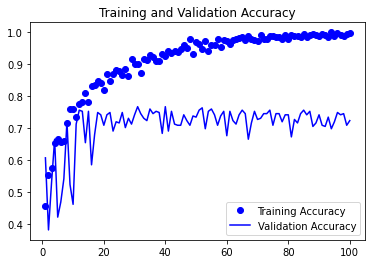

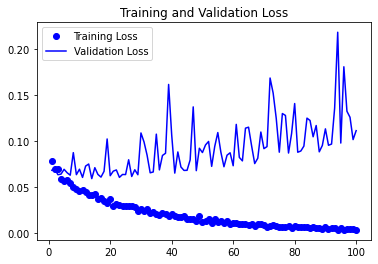

<Figure size 432x288 with 0 Axes>

In [34]:
epochs = range(1, len(accuracy) + 1)

# Accuracy Plots
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

"""
# Generate acc loss percentages
train_loss, train_acc, train_precision, train_recall, train_f1, train_mcc = augmentedVGG16.evaluate_generator(train_aug_generator, steps=len(train_aug_generator))
print("\ntrain_acc: ", train_acc)
print("train_precision: ", train_precision)
print("train_recall: ", train_recall)
print("train_f1: ", train_f1)
print("train_mcc: ", train_mcc)
print("train_loss: ", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1, valid_mcc = augmentedVGG16.evaluate_generator(validation_aug_generator, steps=len(validation_aug_generator))
print("\nvalid_acc: ", valid_acc)
print("valid_precision: ", valid_precision)
print("valid_recall: ", valid_recall)
print("valid_f1: ", valid_f1)
print("valid_mcc: ", valid_mcc)
print("valid_loss: ", valid_loss)
"""

# Output best epoch acc loss percentages
best_loss, best_acc = VGG16_best.evaluate_generator(validation_aug_generator, steps=len(validation_aug_generator))
print("\nbest_avg_acc: ", best_acc)
print("best_avg_loss: ", best_loss)

# Classification metric matrix: precision, recall, f1-score, support
val_preds = np.round(VGG16_best.predict_generator(validating_generator),0)
val_trues = validation_aug_generator.classes

# Label data
classes = np.array(list(validating_generator.class_indices.keys()))

print(classification_report(val_trues, val_preds, target_names = classes))

## Fine Tune

In [35]:
base_directory = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/Models/VGG16_Aug_FL_Acc_FT - 2_0/"
best_model_file = base_directory + "best_model.hdf5"
history_file_name = base_directory + "History.pkl"
info_file_name = base_directory + "README.md"
model_content = """Base: VGG16_best\n
Augmentation: 5 degree, width_shift: [-0.01, 0.01], height_shift: [-0.01, 0.01], zoom_range: [1-0.01, 1+0.01]\n
Batch_size: 32\n
Optimizer: RMSProp\n
Lr: 1e-5\n 
Loss: Focal Loss Fixed\n
Metric: Accuracy\n
Epochs: 100
"""

with open(info_file_name, 'w') as readme_file:
       readme_file.write(model_content)

### Set trainable higher layers

In [36]:
VGG16_best.get_layer(name="vgg16").summary()
vgg16_base = VGG16_best.get_layer(name="vgg16")
vgg16_base.trainable = True

set_trainable = False
for layer in vgg16_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
VGG16_best.get_layer(name="vgg16").summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 255, 255, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 255, 255, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 127, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 127, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 127, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 63, 63, 128)       0     

### Compile and fit

In [37]:
# Model Compile
VGG16_best.compile(optimizer=optimizers.RMSprop(lr=1e-5),
                         loss=focal_loss_fixed,
                         metrics=['acc'])

In [38]:
# Create checkpoint callback to store best acc to loss model
checkpoint = ModelCheckpoint(filepath=best_model_file, save_best_only=True)

# Fit model
VGG16_FT_history = VGG16_best.fit_generator(
    train_aug_generator,
    steps_per_epoch=len(train_aug_generator),
    epochs=100,
    callbacks=[checkpoint],
    validation_data=validation_aug_generator,
    validation_steps=len(validation_aug_generator))

save_history = VGG16_FT_history.history
# Save history
with open(history_file_name, 'wb') as file_pi:
        pickle.dump(save_history, file_pi)

Epoch 1/100
18/18 [==============================] - 9s 526ms/step - loss: 0.0404 - acc: 0.8108 - val_loss: 0.0877 - val_acc: 0.7527
Epoch 2/100
18/18 [==============================] - 7s 416ms/step - loss: 0.0333 - acc: 0.8468 - val_loss: 0.0708 - val_acc: 0.7455
Epoch 3/100
18/18 [==============================] - 8s 433ms/step - loss: 0.0356 - acc: 0.8450 - val_loss: 0.0827 - val_acc: 0.5055
Epoch 4/100
18/18 [==============================] - 8s 432ms/step - loss: 0.0266 - acc: 0.8865 - val_loss: 0.1013 - val_acc: 0.4545
Epoch 5/100
18/18 [==============================] - 8s 469ms/step - loss: 0.0231 - acc: 0.8901 - val_loss: 0.0701 - val_acc: 0.6327
Epoch 6/100
18/18 [==============================] - 8s 441ms/step - loss: 0.0263 - acc: 0.8811 - val_loss: 0.0656 - val_acc: 0.7382
Epoch 7/100
18/18 [==============================] - 8s 431ms/step - loss: 0.0229 - acc: 0.9207 - val_loss: 0.0687 - val_acc: 0.7418
Epoch 8/100
18/18 [==============================] - 8s 429ms/step - 

### Retrieving Saved Model and History

In [40]:
with open(history_file_name, 'rb') as file__pi:
    VGG16_FT_history = pickle.load(file__pi)
    
VGG16_FT_best = models.load_model(best_model_file, custom_objects={"focal_loss_fixed": focal_loss_fixed})
# Temp Comment out
# , "get_f1": get_f1, "matthews_correlation": matthews_correlation

### Plotting Results

In [41]:
accuracy = VGG16_FT_history['acc']
validation_accuracy = VGG16_FT_history['val_acc']

loss = VGG16_FT_history['loss']
validation_loss = VGG16_FT_history['val_loss']

"""
precision = VGG16_augmented_fine_tune_history['precision_1']
validation_precision = VGG16_augmented_fine_tune_history['val_precision_1']
recall = VGG16_augmented_fine_tune_history['recall_1']
validation_recall = VGG16_augmented_fine_tune_history['val_recall_1']
f1 = VGG16_augmented_fine_tune_history['get_f1']
validation_f1 = VGG16_augmented_fine_tune_history['val_get_f1']
mcc = VGG16_augmented_fine_tune_history['matthews_correlation']
validation_mcc = VGG16_augmented_fine_tune_history['val_matthews_correlation']
"""

"\nprecision = VGG16_augmented_fine_tune_history['precision_1']\nvalidation_precision = VGG16_augmented_fine_tune_history['val_precision_1']\nrecall = VGG16_augmented_fine_tune_history['recall_1']\nvalidation_recall = VGG16_augmented_fine_tune_history['val_recall_1']\nf1 = VGG16_augmented_fine_tune_history['get_f1']\nvalidation_f1 = VGG16_augmented_fine_tune_history['val_get_f1']\nmcc = VGG16_augmented_fine_tune_history['matthews_correlation']\nvalidation_mcc = VGG16_augmented_fine_tune_history['val_matthews_correlation']\n"


best_acc:  0.7381818
best_loss:  0.06608028709888458
              precision    recall  f1-score   support

          AD       0.60      0.75      0.67        97
          CN       0.84      0.73      0.78       178

    accuracy                           0.74       275
   macro avg       0.72      0.74      0.73       275
weighted avg       0.76      0.74      0.74       275



'\n# Output best epoch acc loss percentages\nbest_test_loss, best_test_acc, best_test_precision, best_test_recall, best_test_f1, best_test_mcc = VGG16_augmented_fine_tune_best.evaluate_generator(test_aug_generator, steps=len(test_aug_generator))\nprint("\nbest_test_acc: ", best_test_acc)\nprint("best_test_precision: ", best_test_precision)\nprint("best_test_recall: ", best_test_recall)\nprint("best_test_f1: ", best_test_f1)\nprint("best_test_mcc: ", best_test_mcc)\nprint("best_test_loss: ", best_test_loss)\n'

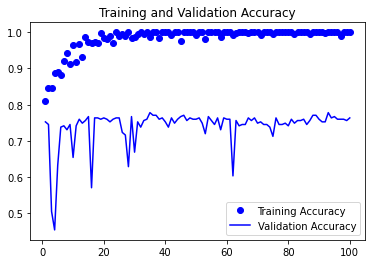

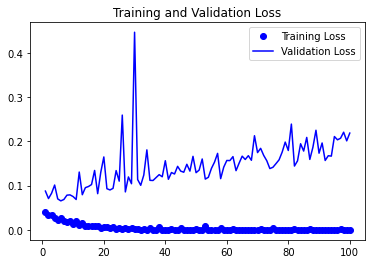

<Figure size 432x288 with 0 Axes>

In [42]:
epochs = range(1, len(accuracy) + 1)


# Accuracy Plots
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

"""
# F1 Plots
plt.plot(epochs, f1, 'bo', label='Training F1')
plt.plot(epochs, validation_f1, 'b', label='Validation F1')
plt.title("Training and Validation F1")
plt.legend()

plt.figure()

# Generate acc loss percentages
train_loss, train_acc, train_precision, train_recall, train_f1, train_mcc = VGG16_aug_best.evaluate_generator(train_aug_generator, steps=len(train_aug_generator))
print("\ntrain_acc: ", train_acc)
print("train_precision: ", train_precision)
print("train_recall: ", train_recall)
print("train_f1: ", train_f1)
print("train_mcc: ", train_mcc)
print("train_loss: ", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1, valid_mcc = VGG16_aug_best.evaluate_generator(validation_aug_generator, steps=len(validation_aug_generator))
print("\nvalid_acc: ", valid_acc)
print("valid_precision: ", valid_precision)
print("valid_recall: ", valid_recall)
print("valid_f1: ", valid_f1)
print("valid_mcc: ", valid_mcc)
print("valid_loss: ", valid_loss)
"""


# Output best epoch acc loss percentages
best_loss, best_acc = VGG16_FT_best.evaluate_generator(validation_aug_generator, steps=len(validation_aug_generator))
print("\nbest_acc: ", best_acc)
print("best_loss: ", best_loss)



# Classification metric matrix: precision, recall, f1-score, support
val_preds = np.round(VGG16_FT_best.predict_generator(validating_generator),0)
val_trues = validation_aug_generator.classes

# Label data
classes = np.array(list(validating_generator.class_indices.keys()))

print(classification_report(val_trues, val_preds, target_names = classes))

### Testing
"""
# Output best epoch acc loss percentages
best_test_loss, best_test_acc, best_test_precision, best_test_recall, best_test_f1, best_test_mcc = VGG16_augmented_fine_tune_best.evaluate_generator(test_aug_generator, steps=len(test_aug_generator))
print("\nbest_test_acc: ", best_test_acc)
print("best_test_precision: ", best_test_precision)
print("best_test_recall: ", best_test_recall)
print("best_test_f1: ", best_test_f1)
print("best_test_mcc: ", best_test_mcc)
print("best_test_loss: ", best_test_loss)
"""